In [146]:
import torch
import torch.nn.functional as F
from typing import List, Tuple, Optional, Any
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [147]:
torch.set_default_dtype(torch.float32)

In [148]:
# build vocabulary
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

vocab = sorted(list(set(''.join(words))))

stoi = {s:i for i,s in enumerate(vocab, start=1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [149]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y

In [150]:
# train, val, test split
random.shuffle(words)

train_split = .8; val_split = .1

n1 = int(train_split * len(words))
n2 = int((train_split + val_split) * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [151]:
g = torch.Generator().manual_seed(2147483647)

In [152]:
# utility fn to compare gradients calc manually v/s via PyTorch
def cmp(s, dt: torch.Tensor, t: torch.Tensor):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [153]:
#IMP FOR THIS NOTEBOOK: CHANGE SOME INIT VALUES AS ZEROS MAY MASK SOME INCORRECT GRADIENT IMPL, **JUST FOR LEARNING PURPOSES**

# build MLP

# MLP structure params
emb_dim_size = 10
hidden_layer_size = 64

# MLP params
C = torch.randn((vocab_size, emb_dim_size), generator=g).float() # represent each character in dim space
#Layer 1
W1 = torch.randn((block_size * emb_dim_size, hidden_layer_size), generator=g).float() # weights for hidden layer, for each neuron, it will receive block_size number of i/p, each i/p of dimension dim_size
W1 = W1 * (5/3) / ((block_size * emb_dim_size) ** 0.5) # kiming_init - to "fight the contraction of tanh", preserve gaussian std. -> to resolve tanh saturation
b1 = torch.randn(hidden_layer_size, generator=g).float() # each neuron will have 1-D bias # USING BIAS JUST FOR FUN
b1 = b1 * 0.1 # normally: 0.001 # to resolve tanh saturation
# Layer 2
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g).float() # weights for output layer, each neuron of hidden layer fully connected to each neuron of output layer
W2 = W2 * 0.1 # to normalize loss at initialization
b2 = torch.randn(vocab_size, generator=g).float() # num_neurons in output layer equal to vocab size, to represent probs for each character
b2 = b2 * 0.1 # normally 0 # to normalize loss at initialization

## batch norm params: want the distribution to be more flexible, not constrict it to be always Gaussian, just need at initialization.
# batch_norm_gain = torch.ones((1, hidden_layer_size))
# batch_norm_bias = torch.zeros((1, hidden_layer_size))
# change from normal, normal above
batch_norm_gain = torch.randn((1, hidden_layer_size)) * 0.1 + 1.0
batch_norm_bias = torch.randn((1, hidden_layer_size)) * 0.1

params = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]

running_mean = torch.zeros((1, hidden_layer_size))
running_std = torch.ones((1, hidden_layer_size))

print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

4137


In [154]:
batch_size =32
n = batch_size
# construct minibatch
ix = torch.randint(0, X_train.shape[0], (n, ), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [155]:
# FORWARD PASS: CHUNKED INTO SIMPLE, MANAGEABLE STEPS THAT CAN BE BACKPROP'ED ONE AT A TIME

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# -----------Linear layer 1---------------
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# ----------BatchNorm layer---------------
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # Bessel's correction, dividing by (n-1) not n, for mean calc
with torch.no_grad():
    epsilon = 1e-5
bnvar_inv = (bnvar + epsilon) ** -0.5  # inverse of "bnstd"
bnraw = bndiff * bnvar_inv
hpreact = batch_norm_gain * bnraw + batch_norm_bias
# ----------Non-linearity---------------
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2
# cross-entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability ??
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in params:
    p.grad = None


gradvars = [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb
]

for t in gradvars:
    t.retain_grad()

loss.backward()

loss

tensor(3.4235, grad_fn=<NegBackward0>)

In [156]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [157]:
#backprop through the grads array manually

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n # loss = -dlogprobs[range(n), Yb].mean() => loss = -(a + b + c) / 3 => dloss/da = -1/3 n = 32 in our case (batch size)

dprobs = 1.0/probs # logprobs = probs.log() => log(a) => dlogprobs/da = 1/a
dprobs = dprobs * dlogprobs # chain rule

# c = a * b
# tensor
# c[3x3] = a[3x3] * b[3x1]
# c1 = a11*b1  a12*b1  a13*b1
# c2 = a21*b2  a22*b2  a23*b2
# c3 = a31*b1  a32*b2  a33*b3

dcounts_sum_inv = counts # probs = counts * counts_sum_inv => probs = b * a, dprobs/da = b
dcounts_sum_inv = dcounts_sum_inv * dprobs # chain rule
dcounts_sum_inv = dcounts_sum_inv.sum(1, keepdim=True) # sum through pytorch replication => m1 [3X1] => m2 [3x3] so gradients would be summed across rows
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

# dcounts --- 1st contribution (from probs)
dcounts = counts_sum_inv # probs = counts * counts_sum_inv => probs = b * a, dprobs/db = a
dcounts = dcounts * dprobs # chain rule #TODO: Investigate why dcounts *= dprobs doesn't work here. Look at shapes for hint.

dcounts_sum = (-counts_sum ** -2)# counts_sum_inv = counts_sum ** -1, y = x**-1, dy/dx = -x**-2
dcounts_sum = dcounts_sum * dcounts_sum_inv # chain rule

# dcounts --- 2nd contribution (from counts_sum)
# a[3x3] -> b[3x1] (rows summed)
# a11 a12 a13   b1 = a11 + a12 + a13
# a21 a22 a23   b2 = a21 + a22 + a23
# a31 a32 a33   b3 = a31 + a32 + a33

# db/da = [1 1 1] (3x1)

dcounts = dcounts + (torch.ones(counts.shape) * dcounts_sum)

# dnorm_logits
# counts = norm_logits.exp() # both of same shape
# y = e ** x
# dy/dx = e ** x = y
dnorm_logits = counts * dcounts # chain rule

# dlogit_maxes
# norm_logits = logits - logit_maxes
# y = a - x
# dy/dx = -1
# however, norm_logits.shape = [n, vocab_size], logit_maxes.shape = [n, 1]
# so, need to do backprop for broadcasting(replication) as well, sum across rows
dlogit_maxes = -(torch.ones_like(logit_maxes) * dnorm_logits).sum(1, keepdim=True)

# dlogits
# contribution 1
# norm_logits = logits - logit_maxes
# y = x - a
# dy/dx = 1
dlogits = torch.ones_like(logits) * dnorm_logits # this will make approximate=True but not exact

# contribution 2
# logit_maxes = logits.max(1, keepdim=True)
# so dlogit_maxes/dlogits = 0 for non-max elements in logits and 1 for the max element
# start with torch.zeros and then make the max elements 1
# clean way -> (logits == logit_maxes).float() -> will be 1 for max elements and 0 otherwise
dlogits = dlogits + ((logits == logit_maxes).float()) * dlogit_maxes

# dh
# logits = h @ W2 + b2
# shapes: W2 = [n_hidden, vocab_size], h = [n, n_hidden], logits = [n, vocab_size]
# dlogits/dh comes out to be upstream gradient (dlogits) @ transpose of W2
# check appendix complete handwritten impl. (navigate using below cell)
dh = dlogits @ W2.T

#dW2
# logits = h @ W2 + b2
# shapes: W2 = [n_hidden, vocab_size], h = [n, n_hidden], logits = [n, vocab_size]
# dlogits/dW2 comes out to be transpose of upstream gradient(dlogits.T) @ h
# check appendix complete handwritten impl. (navigate using below cell)
dW2 = (dlogits.T @ h).T

#db2
# logits = h @ W2 + b2
# shapes: W2 = [n_hidden, vocab_size], h = [n, n_hidden], logits = [n, vocab_size]
# dlogits/db2 comes to be sum of dlogits summed over the columns
# it can also be written as the matmul of dlogits.T and the ones column vector of shape dlogits
# check appendix complete handwritten impl. (navigate using below cell)
#db2 = (dlogits.T @ torch.ones((dlogits.shape[0],1))).squeeze() # approximate = True, exact = False, possibly due to matmuls and float errors, mathematically same as below
db2 = dlogits.sum(0)

# hpreact
# h = torch.tanh(hpreact)
# shapes: same
# y = tanh(x), dy/dx = 1-(tanh(x) ** 2) = 1-y**2
dhpreact = (1.0-h**2) * dh # approximate = True, exact = False

# dbatch_norm_gain
# hpreact = batch_norm_gain * bnraw + batch_norm_bias
# shapes: hpreact: [n, n_hidden], bnraw: [n, n_hidden], batch_norm_gain: [1, n_hidden], batch_norm_bias: [1, n_hidden]
# y = a * x + b
# dy/dx = a
# batch_norm_gain is broadcasted to [n, n_hidden] and then element-wise multiplied with bnraw
# so, need to sum over rows for dbatch_norm_gain
dbatch_norm_gain = (bnraw * dhpreact).sum(0, keepdim=True) # approximate = True, exact = False

# dbatch_norm_bias
# hpreact = batch_norm_gain * bnraw + batch_norm_bias
# shapes: hpreact: [n, n_hidden], bnraw: [n, n_hidden], batch_norm_gain: [1, n_hidden], batch_norm_bias: [1, n_hidden]
# y = a * x + b
# dy/db = 1
# batch_norm_bias is broadcasted to [n, n_hidden] and then element-wise added to bnraw * batch_norm_gain
# so, need to sum over rows for dbatch_norm_bias
dbatch_norm_bias = dhpreact.sum(0, keepdim=True)

# dbnraw
# hpreact = batch_norm_gain * bnraw + batch_norm_bias
# shapes: same
# y = a * x + b
# dy/da = x
# no need for broadcasting as bnraw and dhpreact have same shape
dbnraw = batch_norm_gain * dhpreact

# dbndiff
# contribution 1 --- from bnraw
# bnraw = bndiff * bnvar_inv
# shapes: bnraw: [n, n_hidden], bndiff: [n, n_hidden], bnvar_inv: [1, n_hidden]
# y = x * a
# dy/dx = a
# no need for broadcasting as bnraw and bndiff have same shape
dbndiff = bnvar_inv * dbnraw

# dbnvar_inv
# bnraw = bndiff * bnvar_inv
# shapes: bnraw: [n, n_hidden], bndiff: [n, n_hidden], bnvar_inv: [1, n_hidden]
# y = x * a
# dy/da = x
# bnvar_inv is broadcasted to [n, n_hidden] and then element-wise multiplied to bndiff
# so, need to sum over rows for dbnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

# dbnvar
# bnvar_inv = (bnvar + epsilon) ** -0.5
# shapes: [1, n_hidden], same
# y = (x + a)**-0.5
# dy/dx = (-0.5(x + a)**-1.5) * (d (x + a) /dx) => -0.5 (x + a)**-1.5 => -0.5 y**3
dbnvar = (-0.5 * bnvar_inv ** 3) * dbnvar_inv

# dbndiff2
# bnvar = (
#    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
#)
# shapes: bnvar: [1, n_hidden], bndiff2: [n, n_hidden]
# dy/dx = 1/(n-1) * torch.ones_like(bndiff2) (since for each element in bndiff2, grad will be 1)
dbndiff2 = ((1.0 / (n-1)) * torch.ones_like(bndiff2)) * dbnvar

# dbndiff
# contribution 2 --- from bndiff2
# bndiff2 = bndiff**2
# shapes: same: [n, n_hidden]
# y = x ** 2
# dy/dx = 2 * x + prev_grad
dbndiff += ((2.0 * bndiff) * dbndiff2)

# dhprebn
# contribution 1 --- from bndiff
# bndiff = hprebn - bnmeani
# shapes: bndiff: [n, n_hidden], hprebn: [n, n_hidden], bnmeani: [1, n_hidden]
# y = x - a
# dy/dx = 1 (torch.ones_like(hprebn))
# no need for broadcasting as hprebn and bndiff have same shape
dhprebn = dbndiff.clone()

# dbnmeani
# bndiff = hprebn - bnmeani
# shapes: bndiff: [n, n_hidden], hprebn: [n_hidden], bnmeani: [1, n_hidden]
# y = x - a
# dy/da = -1 -(torch.ones_like(bnmeani))
# need to sum over dbnmeani, due to row-wise replication
dbnmeani = (- 1.0 * (dbndiff)).sum(0, keepdim=True)

# dhprebn
# contribution 2 --- from bnmeani
# bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
# bnmeani: [1, n_hidden], hprebn: [n, n_hidden]
# dy/dx = 1/(n) * torch.ones_like(hprebn) + prev_grad (since for each element in hprebn, grad will be 1) + prev_grad
dhprebn += ((1.0 / n) * torch.ones_like(hprebn)) * dbnmeani

# dembcat
# hprebn = embcat @ W1 + b1
# shapes: hprebn: [n, n_hidden], embcat: [n, block_size * dim_size], W1: [block_size * dim_size, n_hidden], b1: [n_hidden]
# d = a@b+c
# dy/da = upstream_grad @ b.T
# check appendix complete handwritten impl. (navigate using below cell)
dembcat = dhprebn @ W1.T

# dW1
# hprebn = embcat @ W1 + b1
# shapes: hprebn: [n, n_hidden], embcat: [n, block_size * dim_size], W1: [block_size * dim_size, n_hidden], b1: [n_hidden]
# d = a@b+c
# dy/db = a.T @ upstream_grad
# check appendix complete handwritten impl. (navigate using below cell)
dW1 = embcat.T @ dhprebn

# db1
# hprebn = embcat @ W1 + b1
# shapes: hprebn: [n, n_hidden], embcat: [n, block_size * dim_size], W1: [block_size * dim_size, n_hidden], b1: [n_hidden]
# d = a@b+c
# dy/dc = upstream_grad row_wise column element sum
# check appendix complete handwritten impl. (navigate using below cell)
db1 = dhprebn.sum(0, keepdim=True)

# demb
# embcat = emb.view(emb.shape[0], -1)
# shapes: embcat: [n, block_size * dim_size], emb: [n, dim_size, block_size]
# dy/dx: just a dim change is occurring, so backprop would be to flatten the view back to original dimensions.
demb = dembcat.view_as(emb)

#dC
# emb = C[Xb]
# shapes: emb: [n, block_size, dim_size], C: [vocab_size, dim_size], Xb: [n, block_size]
# In forward pass, what's happening for each 3-dim example in Xb (the integer encoding of the character blocks), the corresponding dimension (from C) is fetched and organized into emb.
# So to generate dC, we need to get the vocab's corresponding gradient that's sitting in demb and add it to dc
# But we need to accumulate gradients as one vocab letter may be used in multiple examples in Xb, and therefore emb.
# so dC will be a tensor of zeros of shape like C, but at the indices of Xb, the value will be 1
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
            ix = Xb[k, j]
            dC[ix] += demb[k, j]


# All comparisons
cmp('logprob', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbatch_norm_gain', dbatch_norm_gain, batch_norm_gain)
cmp('dbatch_norm_bias', dbatch_norm_bias, batch_norm_bias)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('dC', dC, C)


logprob         | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
dbatch_norm_gain | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
dbatch_norm_bias | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
dbnra

In [158]:
from IPython.display import HTML
HTML('<a href="#appendix">Go to Appendix</a>')

In [159]:
# backward pass for cross-entropy in one go
loss_fast = F.cross_entropy(logits, Yb)
print(f"Loss_fast: {loss_fast} diff: {loss_fast.item() - loss.item()}")

Loss_fast: 3.423457622528076 diff: 2.384185791015625e-07


In [160]:
# Before: forward pass for cross-entropy loss (same as F.cross_entropy(logits, Yb))
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes  # subtract max for numerical stability ??
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# for a single logit example, the derivative of the loss w.r.t the logit example comes out to be the following:
# --- softmax of the logit (when the logit's index is not equal to Yb)
# --- softmax of the logit - 1 (when the logit's index is equal to Yb)
# see appendix for handwritten impl.
# need to also scale down the derivative over the average, since the final loss is the average over the losses of all the examples.
dlogits = F.softmax(logits, dim=1) # need to do softmax over the rows
dlogits[range(logits.shape[0]), Yb] -= 1.0
dlogits /= n
cmp('dlogits', dlogits, logits) 

dlogits         | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [161]:
F.softmax(logits, 1)[0]

tensor([0.0353, 0.0235, 0.0194, 0.0236, 0.0258, 0.0723, 0.0369, 0.0350, 0.0318,
        0.0250, 0.0224, 0.0345, 0.0686, 0.0481, 0.0216, 0.0240, 0.0278, 0.0236,
        0.0346, 0.0547, 0.0469, 0.0159, 0.0377, 0.1067, 0.0634, 0.0182, 0.0227],
       grad_fn=<SelectBackward0>)

In [162]:
dlogits[0] * n

tensor([ 0.0353,  0.0235,  0.0194,  0.0236,  0.0258,  0.0723,  0.0369,  0.0350,
         0.0318,  0.0250,  0.0224,  0.0345,  0.0686,  0.0481,  0.0216,  0.0240,
        -0.9722,  0.0236,  0.0346,  0.0547,  0.0469,  0.0159,  0.0377,  0.1067,
         0.0634,  0.0182,  0.0227], grad_fn=<MulBackward0>)

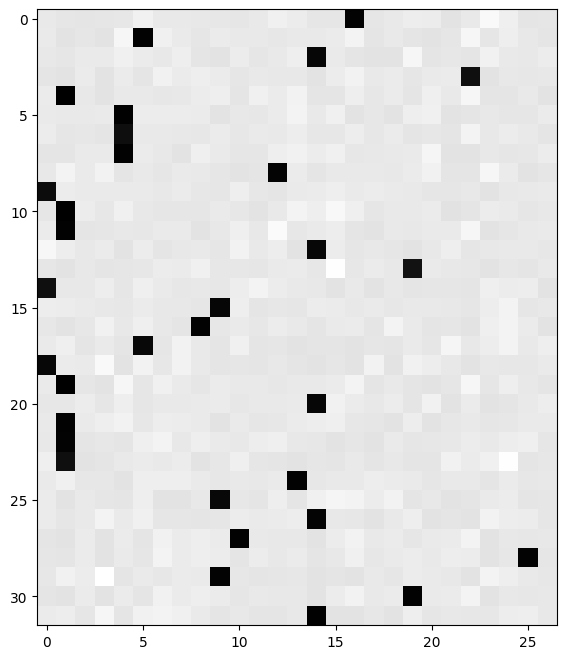

In [163]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap="gray")

In [164]:
# backprop through batchnorm in one go
# IMP: Look at the expression for the output of batchnorm, 
# take the derivative w.r.t the input, simplify the expression and just write it out

# forward pass
# Before:
# bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = (
#     1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
# )  # Bessel's correction, dividing by (n-1) not n, for mean calc
# with torch.no_grad():
#     epsilon = 1e-5
# bnvar_inv = (bnvar + epsilon) ** -0.5  # inverse of "bnstd"
# bnraw = bndiff * bnvar_inv
# hpreact = batch_norm_gain * bnraw + batch_norm_bias

# now
hpreact_fast = batch_norm_gain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True)) + batch_norm_bias
print(f"diff: {(hpreact_fast - hpreact).abs().max()}")


diff: 2.09808349609375e-05


# Appendix
## Matmul Backprop Calculation
![Matmul Backprop Steps](assets/matmul_backprop/IMG_20250131_191121501_HDR.jpg)
### (Continued)
![Matmul Backprop Steps (contd.)](assets/matmul_backprop/IMG_20250131_191127782_HDR.jpg)